<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)"> Predictive Analysis - Image Processing</h2>

[source](https://medium.com/swlh/classifying-fashion-mnist-dataset-with-convolutional-neural-nets-dd092d755164)

!pip3 install -U opencv-python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from sklearn.metrics import accuracy_score
from keras.datasets import fashion_mnist

2022-02-12 11:58:05.794025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/renato/Documents/env_default/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-12 11:58:05.794082: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print('Shape:')
print('X_Train {}'.format(x_train.shape))
print('Y_Train {}'.format(y_train.shape))
print('X_Test {}'.format(x_test.shape))
print('Y_Test {}'.format(y_test.shape))

Shape:
X_Train (60000, 28, 28)
Y_Train (60000,)
X_Test (10000, 28, 28)
Y_Test (10000,)


In [3]:
def check_samples(sample, plot=True):
    counter = {}
    for key in sample:
        if key not in counter.keys():
            counter[key] = 1
        else:
            counter[key] = counter[key] + 1
    df_dict = {'cat':[x for x in counter.keys()], 
               'cnt':[y for y in  counter.values()]}
    cnt_df = pd.DataFrame(df_dict)
    if plot:
        sns.barplot(data=cnt_df, x='cat', y='cnt')
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.title('# of Obs. in each Category')
        return None
    else:
        return cnt_df

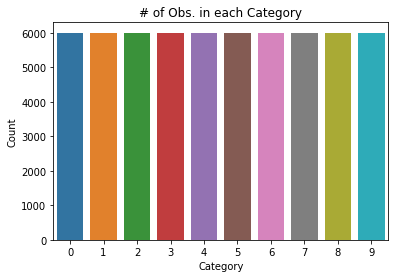

In [4]:
check_samples(y_train)

In [5]:
#Scale Image
def scale_img(dim, img):
    resized_img = cv2.resize(np.asarray(img), dim, interpolation = cv2.INTER_AREA)
    return resized_img

#Normalize Image
def normalize_img(img, is_gray = False):
    normalized_img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    if is_gray:
        cvt = cv2.cvtColor(normalized_img, cv2.COLOR_BGR2GRAY)
        return cvt
    return normalized_img

#Rotate Image
def rotate_img(img, rot_deg):
    rows,cols = img.shape[0], img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),rot_deg,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst

#Translate Image
def translate_img(img,x=100,y=50):
    rows,cols = img.shape[0], img.shape[1]
    M = np.float32([[1,0,x],[0,1,y]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst

In [6]:
x_train_tran = x_train.tolist()
y_train_tran = y_train.tolist()
ctr = 0
for img in x_train:
    x_train_tran.append(rotate_img(img, 90))
    y_train_tran.append(y_train[ctr])
    x_train_tran.append(translate_img(img, x=15, y=15))
    y_train_tran.append(y_train[ctr])
    ctr = ctr + 1
    
x_train_tran = np.array(x_train_tran).reshape(len(x_train_tran), 28, 28, 1)
y_train_tran = tf.keras.utils.to_categorical(np.array(y_train_tran))
#x_train_tran, y_train_tran = shuffle(x_train_tran, y_train_tran)

print('Shape:')
print('X_Train {}'.format(x_train_tran.shape))
print('Y_Train {}'.format(y_train_tran.shape))

Shape:
X_Train (180000, 28, 28, 1)
Y_Train (180000, 10)


In [7]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), activation='relu',input_shape=(28,28,1)))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3)))
cnn_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(32, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(tf.keras.utils.to_categorical(y_train).shape[1], activation='softmax'))

2022-02-12 11:58:14.063771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 11:58:14.065190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/renato/Documents/env_default/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-12 11:58:14.065346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/renato/Documents/env_default/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-12 11:58:14.065481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libc

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=15, verbose=2, mode='auto')

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(x_train_tran, y_train_tran, batch_size=32, epochs=150, callbacks=[es])

Epoch 1/150


2022-02-12 11:58:14.165703: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1128960000 exceeds 10% of free system memory.


5625/5625 [==============================] - 65s 11ms/step - loss: 0.9149 - accuracy: 0.6577
Epoch 2/150
5625/5625 [==============================] - 68s 12ms/step - loss: 0.7128 - accuracy: 0.7224
Epoch 3/150
5625/5625 [==============================] - 71s 13ms/step - loss: 0.6567 - accuracy: 0.7408
Epoch 4/150
5625/5625 [==============================] - 67s 12ms/step - loss: 0.6295 - accuracy: 0.7511
Epoch 5/150
5625/5625 [==============================] - 63s 11ms/step - loss: 0.6063 - accuracy: 0.7613
Epoch 6/150
5625/5625 [==============================] - 65s 11ms/step - loss: 0.5929 - accuracy: 0.7655
Epoch 7/150
5625/5625 [==============================] - 65s 12ms/step - loss: 0.5801 - accuracy: 0.7711
Epoch 8/150
5625/5625 [==============================] - 63s 11ms/step - loss: 0.5687 - accuracy: 0.7753
Epoch 9/150
5625/5625 [==============================] - 62s 11ms/step - loss: 0.5612 - accuracy: 0.7782
Epoch 10/150
5625/5625 [==============================] - 62s 11ms/

In [ ]:
preds = cnn_model.predict(x_test_tran)
pred_list = []
for i in preds:
    pred_list.append(np.argmax(i))

print('{}%'.format(accuracy_score(y_pred=pred_list,y_true=y_test) * 100))

In [ ]:
class_map = {0:'T-shirt/top',
             1:'Trouser',
             2:'Pullover',
             3:'Dress',
             4:'Coat',
             5:'Sandal',
             6:'Shirt',
             7:'Sneaker',
             8:'Bag',
             9:'Ankle boot'}

true_class_ct = {}

for i in range(10):
    true_class_ct[class_map[i]] = sum(1 for x in incorrect_df['true'] if x == class_map[i])
    pred_class_ct = {}
for i in range(10):
    pred_class_ct[class_map[i]] = sum(1 for x in incorrect_df['pred'] if x == class_map[i])
    
pred_class_ctop = {}

def percentage_error(trueval, changedval, i):
    op[class_map[i]] = ((changedval - trueval)/trueval) * 100
    
for ct in range(10):
    tv = true_class_ct[class_map[ct]]
    cv = pred_class_ct[class_map[ct]]
    percentage_error(tv, cv, ct)
    
fig, ax = plt.subplots()
width = 0.4
x = np.arange(10)
rects1 = ax.bar(x - width/2, list(true_class_ct.values()), width, label='True')
rects2 = ax.bar(x + width/2, list(pred_class_ct.values()), width, label='CNN Predicted')

ax.set_ylabel('Count')
ax.set_title('Classification Error in each class')
ax.set_xticks(x)
ax.set_xticklabels(list(op.keys()))
ax.legend()
plt.xticks(rotation=45)

In [ ]:
sns.barplot(x=list(op.keys()), y=list(op.values()))
plt.ylabel("Percentage")
plt.title('Percentage error for each class')
plt.xticks(rotation=45)
plt.xlabel('Classes')

Sneakers seems to be a problem. The model classified 60% more samples as sneakers than the original samples that were sneakers. Percentage, however, by itself is not enough. If we consider both bar charts, we can see that our model is overfitting few categories. There are few ways to avoid that.

+ Regularization (L1/L2)
+ Adding Dropout Layers
+ Adding more data by data augmentation (which we did).

Model fitting in my opinion is an iterative process. You begin with a model that you think has best hyperparameters to understand data. You then assess the model to see how well it performs on the training data using metrics like accuracy, loss etc. If the model seems to be not doing great, you tweak the hyperparameters and fit the model again until you reach a desired model. Hypothetically, a desired model is the one that has close to 100% accuracy and, that does not over or under-fit on training set and is not biased.